# Reducing the core circuit depth using dynamic circuits and tailored initial layouts.

## Motivation

The final core circuit for two emitters derived in `02_two_emitters_and_one_cavity.ipynb` and generalized in `03_generalization_to_different_emitters.ipynb` and `04_scaling_up_to_n_emitters.ipynb`, although expected to scale constant with the number of emitters, still has a significant pre-scaling factor mainly due to the $CCR_y$ gates. These gates can be decomposed as seen below,

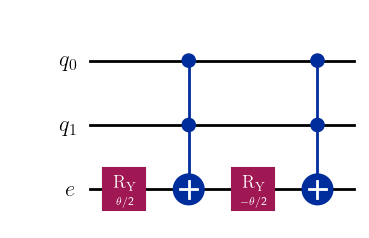

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RYGate
from qiskit.circuit import Parameter

system = QuantumRegister(2, 'q')
environment = QuantumRegister(1, 'e')
qc = QuantumCircuit(system, environment)

theta = Parameter('$\\theta$')

ccry = RYGate(theta).control(2)

qc.append(ccry, [system[0], system[1], environment[0]])
a = qc.decompose().draw('mpl')
a.savefig('figures/ccry_decomposition.png')
a

with each CCX or Toffoli gate consisting of six CX gates and some single qubit gates


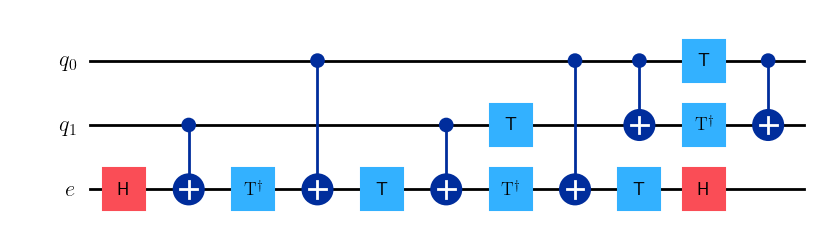

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RYGate
from qiskit.circuit import Parameter

system = QuantumRegister(2, 'q')
environment = QuantumRegister(1, 'e')
qc = QuantumCircuit(system, environment)
qc.ccx(system[0], system[1], environment[0])

a = qc.decompose().draw('mpl')
a.savefig('figures/toffoli_decomposition.png')
a

These end up contributing significantly to the high two-qubit depth of the core circuit, whose scaling before and after transpilation can be seen in the graph below.

NOTE TO SELF: Max number of molecules around 15 ($n=20$ does not run in 24 hours)

In [1]:
from main_functions.generalized_original_circuit import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = service.backend('ibm_marrakesh')
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)

omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [2, 3, 4, 5, 6, 7, 8, 9, 10]

virtual_tqd = []
transpiled_tqd=[]

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.8) for x in range(i)]
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
    g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[0] = 1

    qc = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r)
    decomposed_qc = qc.decompose(reps = 2)

    trans_qc = pm.run(qc)

    virtual_tqd.append(get_circuit_properties(decomposed_qc)['two qubit depth'])
    transpiled_tqd.append(get_circuit_properties(trans_qc)['two qubit depth'])

    print(f'n = {i} done!')

df = pd.DataFrame({'n' : n_molecules, 'virtual circuit' : virtual_tqd, 'transpiled circuit' : transpiled_tqd})
df.to_csv('data/updated_06_12_marrakesh_original_circuit_tqd_scaling.csv', index = False)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_26560\1591134983.py:8: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!


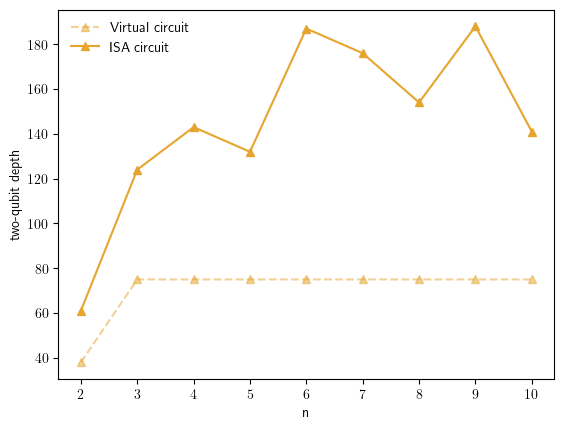

In [ ]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

a = pd.read_csv('data/updated_06_12_marrakesh_original_circuit_tqd_scaling.csv')
plottable_a = a[a['n'] <= 10]

colors = generate_complementary_colors(int((plottable_a.shape[1]-1)/2), 'default', 'orange')

plt.plot(plottable_a['n'], plottable_a['virtual circuit'], marker = '^', color = colors[0], alpha = 0.5, label = 'Virtual circuit', linestyle = 'dashed')
plt.plot(plottable_a['n'], plottable_a['transpiled circuit'], marker = '^', color = colors[0], label = 'ISA circuit')
plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/updated_06_12_marrakesh_original_circuit_tqd_scaling.png', bbox_inches='tight')

Recall from notebook `02_two_emitters_and_one_cavity.ipynb` that the addition of the doubly-controlled $R_y$ gates was needed in order to 'fix' the decay rates of the qubits if they started in the double excited state $\left| E \right> = \left| 11 \right>$. However, we can avoid using these two (very costly) gates by checking first, through a single mid-circuit measurement on an ancillary qubit, whether the system is in that state or not and then perform the pertinent gate operations. This approach is based on a certain type or circuits, whose operations change depending on the outcome of a mid-circuit measurement, called __dynamic circuits__, hence the title of this notebook.

## First approach and adaptation to SamplerV2 (v1)

Dynamic circuits are a type of quantum circuits that make us of classical feedforward and control flow. With classical forward we are referring to the "_ability to measure qubits in the middle of a circuit and perform additional quantum operations that depend on the measurement outcome_" [1](#references). Currently there are some limitations with these type of circuits. For more information, see [2].

Since `EstimatorV2` does not support mid-circuit measurements, the primitive we are forced to use for this approach is `SamplerV2`. The only two things that we need to change are (1) adding `measure_all()` at the end of the Trotterized circuit and (2) defining a function that measures the expectation value of the observable we seek, given some bitstrings and counts. The first one is included in the circuit in `gen_dynamic_circuit_v1.py` and (2) is considered in the solver function in `generalized_sampler_solver.py` 

First of all, let's see how the total (Hamiltonian and dissipative) parametric circuit looks like just for $n=2$.

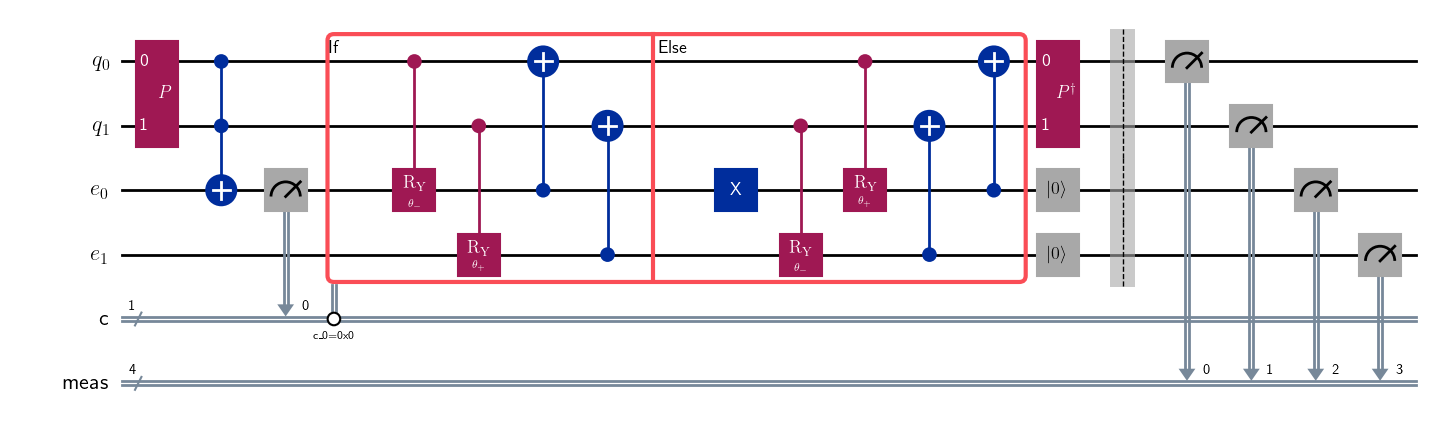

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 2
initial_state = [0]*(2**n)
initial_state[-1] = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(n, name = 'e')
classical_bits = ClassicalRegister(n-1, name = 'c')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = Parameter('$\\tilde{g}$')

tilde_alpha = Parameter('$\\tilde{\\alpha} (\\tilde{g})$')
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

# theta_g_plus = Parameter(r'$\theta_{G+}$')
# theta_g_minus = Parameter(r'$\theta_{G−}$')
# theta_minus_e = Parameter(r'$\theta_{−E}$')
# theta_plus_e = Parameter(r'$\theta_{+E}$')

theta_g_plus = Parameter(r'$\theta_{+}$')
theta_g_minus = Parameter(r'$\theta_{−}$')
theta_minus_e = theta_g_minus
theta_plus_e = theta_g_plus

init = QuantumCircuit(system, environment, classical_bits)
# initial_qubit_state = initial_state    
# initial_statevector = Statevector(initial_qubit_state) 
# init.initialize(params = initial_statevector, qubits = system, normalize = True)

qc = QuantumCircuit(system, environment, classical_bits)

# Free Hamiltonian evolution
#for l in range(r):

    # for i in range(n):

    #     qc.rz(tilde_beta[i], system[i])

    # # Two-layer interaction circuit

    # for j in range(0, n-1, 2):

    #     qc.ryy(tilde_alpha, qubit1 = system[j], qubit2 = system[j+1])
    #     qc.rxx(tilde_alpha, qubit1 = system[j], qubit2 = system[j+1])

# Decay

# P_gate = Gate(name = 'P', params = [omega_eff[0], omega_eff[1], g_eff],num_qubits = 2, label = '$P$')
# P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[0], omega_eff[1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')

P_gate = Gate(name = 'P',  params = [],num_qubits = 2, label = '$P$')
P_dag_gate = Gate(name = 'Pdag', params = [], num_qubits = 2, label = '$P^{\\dag}$')

for j in range(0, n-1, 2):

    qc.append(P_gate, [system[j], system[j+1]])

    qc.ccx(system[j], system[j+1], environment[j])

    qc.measure(environment[j], classical_bits[j])

    # Checking classically for correct parameter assignment

    with qc.if_test((classical_bits[j], 0)) as else_:

        qc.cry(theta_g_minus, system[j], environment[j])
        qc.cry(theta_g_plus, system[j+1], environment[j+1])
        qc.cx(environment[j], system[j])
        qc.cx(environment[j+1], system[j+1])

    with else_:

        qc.x(environment[j]) # To make it go back to 1.
        qc.cry(theta_plus_e, system[j], environment[j])
        qc.cry(theta_minus_e, system[j+1], environment[j+1])
        qc.cx(environment[j], system[j])
        qc.cx(environment[j+1], system[j+1])

    qc.append(P_dag_gate, [system[j], system[j+1]])

    qc.reset([environment[j], environment[j+1]])


parametrized_qc = (qc.compose(init, front = True))
parametrized_qc.measure_all()

a = parametrized_qc.draw('mpl', fold = 70)
a.savefig('poster_dynamic_circuit_v1.png', bbox_inches='tight', transparent = True)
a

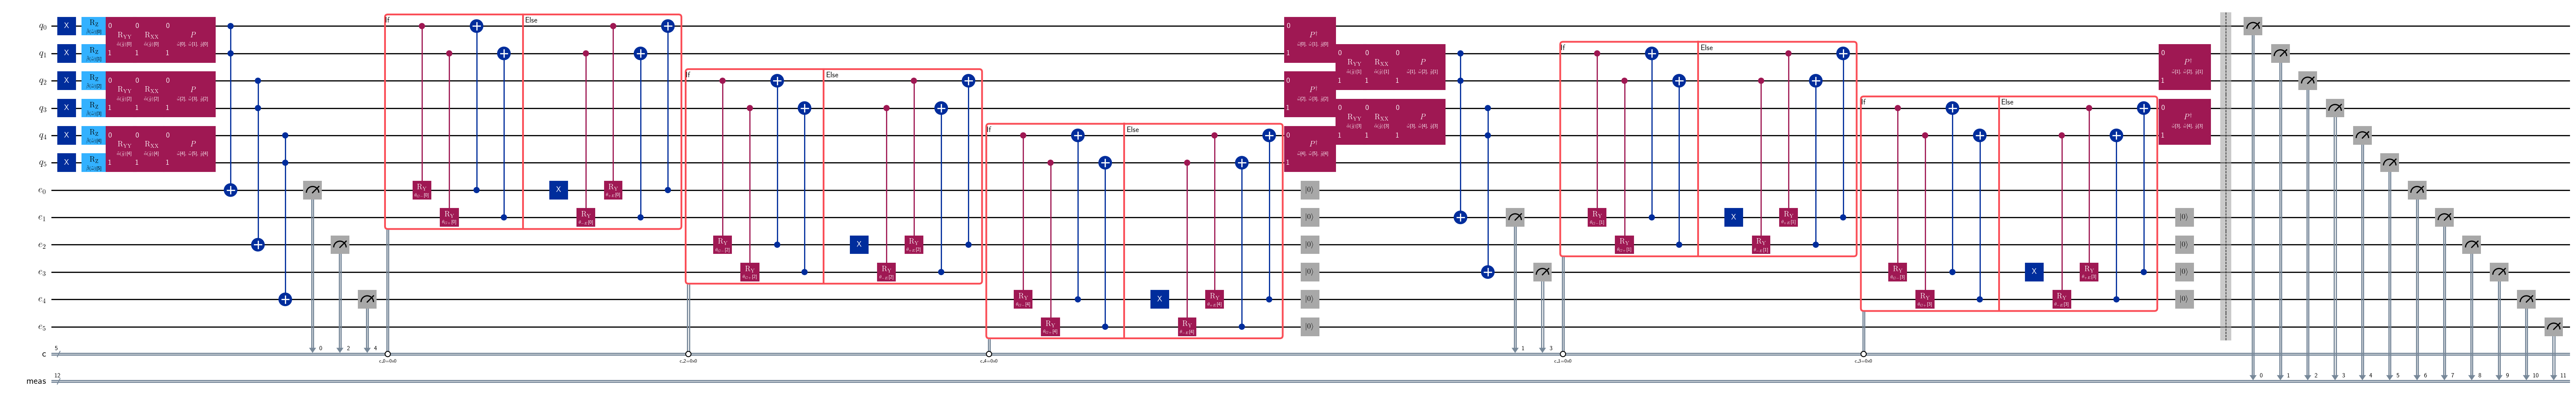

In [23]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 6
initial_state = [0]*(2**n)
initial_state[-1] = 1
r = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(n, name = 'e')
classical_bits = ClassicalRegister(n-1, name = 'c')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = ParameterVector('$\\tilde{g}$', n-1)

tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', n-1)
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

theta_g_plus = ParameterVector(r'$\theta_{G+}$', n-1)
theta_g_minus = ParameterVector(r'$\theta_{G−}$', n-1)
theta_minus_e = ParameterVector(r'$\theta_{−E}$', n-1)
theta_plus_e = ParameterVector(r'$\theta_{+E}$', n-1)

init = QuantumCircuit(system, environment, classical_bits)
#initial_qubit_state = initial_state    
#initial_statevector = Statevector(initial_qubit_state) 
#init.initialize(params = initial_statevector, qubits = system, normalize = True)

for i in range(n):

    init.x(i)

qc = QuantumCircuit(system, environment, classical_bits)

# Free Hamiltonian evolution
for l in range(r):

    for i in range(n):

        qc.rz(tilde_beta[i], system[i])

    # Two-layer interaction circuit

    for j in range(0, n-1, 2):

        qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
        qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

# Decay

    for j in range(0, n-1, 2):

        P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff[j]],num_qubits = 2, label = '$P$')
        P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P^{\\dag}$')

        qc.append(P_gate, [system[j], system[j+1]])

        qc.ccx(system[j], system[j+1], environment[j])

        qc.measure(environment[j], classical_bits[j])

        # Checking classically for correct parameter assignment

        with qc.if_test((classical_bits[j], 0)) as else_:

            qc.cry(theta_g_minus[j], system[j], environment[j])
            qc.cry(theta_g_plus[j], system[j+1], environment[j+1])
            qc.cx(environment[j], system[j])
            qc.cx(environment[j+1], system[j+1])

        with else_:

            qc.x(environment[j]) # To make it go back to 1.
            qc.cry(theta_plus_e[j], system[j], environment[j])
            qc.cry(theta_minus_e[j], system[j+1], environment[j+1])
            qc.cx(environment[j], system[j])
            qc.cx(environment[j+1], system[j+1])

        qc.append(P_dag_gate, [system[j], system[j+1]])

        qc.reset([environment[j], environment[j+1]])

    if n > 2:

        # Two-layer interaction circuit

        for j in range(1, n-2, 2):

            qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
            qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

        # Decay

        for j in range(1, n-2, 2):

            P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff[j]],num_qubits = 2, label = '$P$')
            P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P^{\\dag}$')

            qc.append(P_gate, [system[j], system[j+1]])

            qc.ccx(system[j], system[j+1], environment[j])

            qc.measure(environment[j], classical_bits[j])

            # Checking classically for correct parameter assignment

            with qc.if_test((classical_bits[j], 0)) as else_:

                qc.cry(theta_g_minus[j], system[j], environment[j])
                qc.cry(theta_g_plus[j], system[j+1], environment[j+1])
                qc.cx(environment[j], system[j])
                qc.cx(environment[j+1], system[j+1])

            with else_:

                qc.x(environment[j]) # To make it go back to 1.
                qc.cry(theta_plus_e[j], system[j], environment[j])
                qc.cry(theta_minus_e[j], system[j+1], environment[j+1])
                qc.cx(environment[j], system[j])
                qc.cx(environment[j+1], system[j+1])

            qc.append(P_dag_gate, [system[j], system[j+1]])

            qc.reset([environment[j], environment[j+1]])


parametrized_qc = (qc.compose(init, front = True))
parametrized_qc.measure_all()

a = parametrized_qc.draw('mpl', fold = -1)
a.savefig('figures/generalized_parametric_dynamic_circuit_v1_6_emitters.png', bbox_inches='tight',  transparent=True)
a

After that, we will check if this circuit does indeed yield the same results as the original one.

In [16]:
from main_functions.ME_solver import solve_master_equation
from main_functions.generalized_original_circuit import get_circuit as original_circuit
from main_functions.generalized_estimator_solver import estimator_solver
from main_functions.generalized_sampler_solver import sampler_solver
from main_functions.gen_dynamic_circuit_v1 import get_circuit as dynamic_v1_circuit
import numpy as np
from qiskit_aer import AerSimulator

n = 3
omega_m = [1.8, 1.5, 1.3]
omega_c = 1.2
gamma = [0.8*(10**-6), 1.8*(10**-6), 3.8*(10**-6)]
kappa = [0.2]
g = [0.01, 0.02, 0.01, 0.03] # There are 2*(n-1) couplings in the original problem
t = np.linspace(0, 750, 250)
initial_state = [0]*(2**n) # Coordinates in computational basis
initial_state[-1] = 1

t = np.linspace(0, 750, 250)
r = 15

backend = AerSimulator()
optimization_level = 0
options = {'default_shots' : 10**4}

sampler_qc = dynamic_v1_circuit(n, omega_m, omega_c, g, gamma, kappa, initial_state, r)
evs_sampler = sampler_solver(sampler_qc, n, t, backend, optimization_level, options, None)
estimator_qc = original_circuit(n, omega_m, omega_c, g, gamma, kappa, initial_state, r)
evs_estimator = estimator_solver(estimator_qc, n, t, backend, optimization_level, options)
evs_markov = solve_master_equation(n, omega_m, omega_c, gamma, kappa, g, t, initial_state, 'markovian')

np.savez('data/three_non_identical_emitters_original_circuit_populations', evs_estimator)
np.savez('data/three_non_identical_emitters_dynamical_circuit_v1_populations', evs_sampler)
np.savez('data/three_non_identical_emitters_qutip_populations', evs_markov)

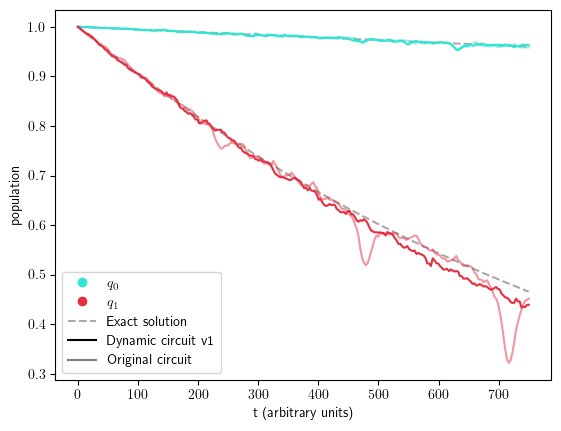

In [17]:
from utils.generate_complementary_colors import generate_complementary_colors
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

plot_qubits = [0, 1]

exact_data = np.load('data/three_non_identical_emitters_qutip_populations.npz', allow_pickle = True)
original_circuit_data = np.load('data/three_non_identical_emitters_original_circuit_populations.npz', allow_pickle = True)
dynamic_circuit_v1_data = np.load('data/three_non_identical_emitters_dynamical_circuit_v1_populations.npz', allow_pickle = True)

exact_pops = exact_data['arr_0'].item()
original_pops = original_circuit_data['arr_0'].item()
dynamic_v1_pops = dynamic_circuit_v1_data['arr_0'].item()

colors = generate_complementary_colors(len(plot_qubits), start_color = 'turquoise')

for q in plot_qubits:

    plt.plot(t, exact_pops[str(q)], color = 'darkgrey', linestyle = 'dashed')
    plt.plot(t, dynamic_v1_pops[str(q)], color = colors[q])
    plt.plot(t, original_pops[str(q)], color = colors[q], alpha = 0.5)

    if len(plot_qubits) > 1:

        plt.plot(np.NaN, np.NaN, linestyle = 'None', marker = 'o', color = colors[q], label = f'$q_{q}$' )

    else:
        
        plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'darkgrey', label = 'Exact solution')
        plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = colors[q], label = 'Dynamic circuit v1')
        plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = colors[q], alpha = 0.5, label = 'Original circuit')

if len(plot_qubits) > 1:

    plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'darkgrey', label = 'Exact solution')
    plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'Dynamic circuit v1')
    plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', alpha = 0.5, label = 'Original circuit')

plt.xlabel('t (arbitrary units)')
plt.ylabel('population')
plt.legend()
plt.savefig('figures/check_results_non_identical_dynamic_circuit_v1_15_trotter.png', bbox_inches='tight')
plt.show()  

After that, we will check if this approach actually reduces the two qubit depth for both the transpiled and virtual quantum circuits.

In [5]:
from main_functions.gen_dynamic_circuit_v1 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd
from qiskit.circuit import IfElseOp

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = service.backend('ibm_fez')
backend.refresh()  # <--- this will refresh the backend data
backend.target.add_instruction(IfElseOp, name="if_else")
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)

omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [2, 3, 4, 5, 6, 7, 8, 9, 10]

virtual_tqd = []
transpiled_tqd = []

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.8) for x in range(i)]
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
    g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[0] = 1

    sampler_qc = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r)

    decomposed_qc = sampler_qc.decompose(reps = 2)

    trans_qc = pm.run(sampler_qc)

    virtual_tqd.append(get_circuit_properties(decomposed_qc)['two qubit depth'])
    transpiled_tqd.append(get_circuit_properties(trans_qc)['two qubit depth'])

    print(f'n = {i} done!')

df = pd.DataFrame({'n' : n_molecules, 'virtual circuit' : virtual_tqd, 'transpiled circuit' : transpiled_tqd})
df.to_csv('data/updated_06_12_fez_dynamic_circuit_v1_tqd_scaling.csv')

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_26560\1035891775.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!


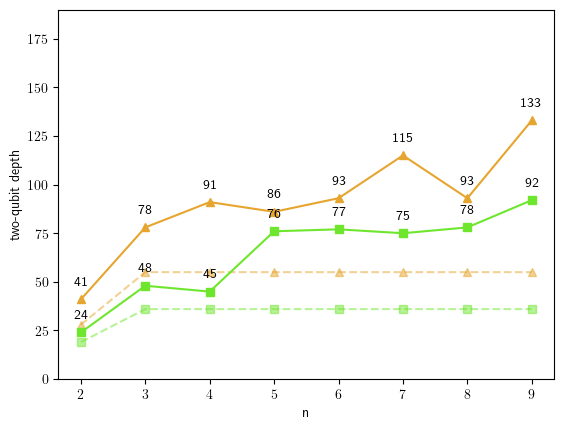

In [7]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_data = pd.read_csv('data/updated_06_12_fez_dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/updated_06_12_marrakesh_original_circuit_tqd_scaling.csv')

plottable_dynamic = dynamic_data[dynamic_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]

colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[0], alpha = 0.5)
plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[0], label = 'Original circuit')
plt.plot(plottable_dynamic['n'], plottable_dynamic['virtual circuit'], linestyle = 'dashed', marker = 's', color = colors[1], alpha = 0.5)
plt.plot(plottable_dynamic['n'], plottable_dynamic['transpiled circuit'], linestyle = 'solid', marker = 's', color = colors[1], label = 'Dynamic circuit v1')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for i, txt in enumerate(plottable_original['transpiled circuit']):

    plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(plottable_dynamic['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic['n'][i], plottable_dynamic['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

#plt.legend(frameon=False)
plt.ylim([0,190])
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/updated_06_12_marrakesh_and_fez_original_vs_dynamic_circuit_v1.png', bbox_inches='tight')

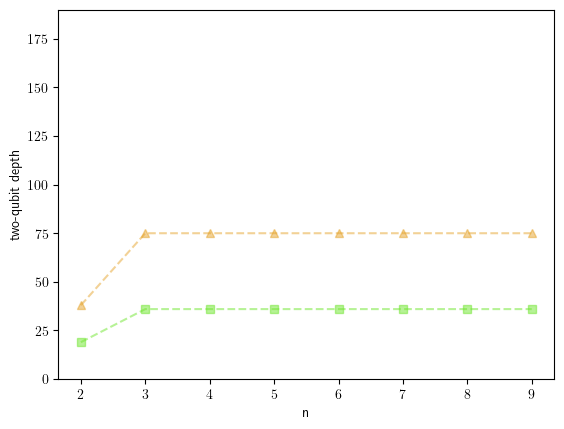

In [6]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
import pandas as pd
import numpy as np
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_data = pd.read_csv('data/dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/original_circuit_tqd_scaling.csv')

plottable_dynamic = dynamic_data[dynamic_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]

colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[0], alpha = 0.5)
#plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[0], label = 'Original circuit')
plt.plot(plottable_dynamic['n'], plottable_dynamic['virtual circuit'], linestyle = 'dashed', marker = 's', color = colors[1], alpha = 0.5)
#plt.plot(plottable_dynamic['n'], plottable_dynamic['transpiled circuit'], linestyle = 'solid', marker = 's', color = colors[1], label = 'Dynamic circuit v1')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

#for i, txt in enumerate(plottable_original['transpiled circuit']):

    #plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

#for i, txt in enumerate(plottable_dynamic['transpiled circuit']):

    #plt.annotate(txt, (plottable_dynamic['n'][i], plottable_dynamic['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

#plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.ylim([0,190])
plt.savefig('figures/original_vs_dynamic_circuit_v1_virtual_tqd_scaling.png', bbox_inches='tight')

## Better ancilla allocation. (v2)


Assigning one ancilla to each qubit makes the circuit (a) very wide, with width $2n$ and (b) very deep due to the high number of SWAPs needed to perform the decay section, especially during the Toffoli(s). Both points can be reduced by allocating just one ancilla per qubit pair. This reduces the width to $n +$ trunc $(n/2)$ and critically reduces the TQD as seen in the comparison below. This version (which we will refer to as v2) and the previous one are both available in the `main_functions` folder.

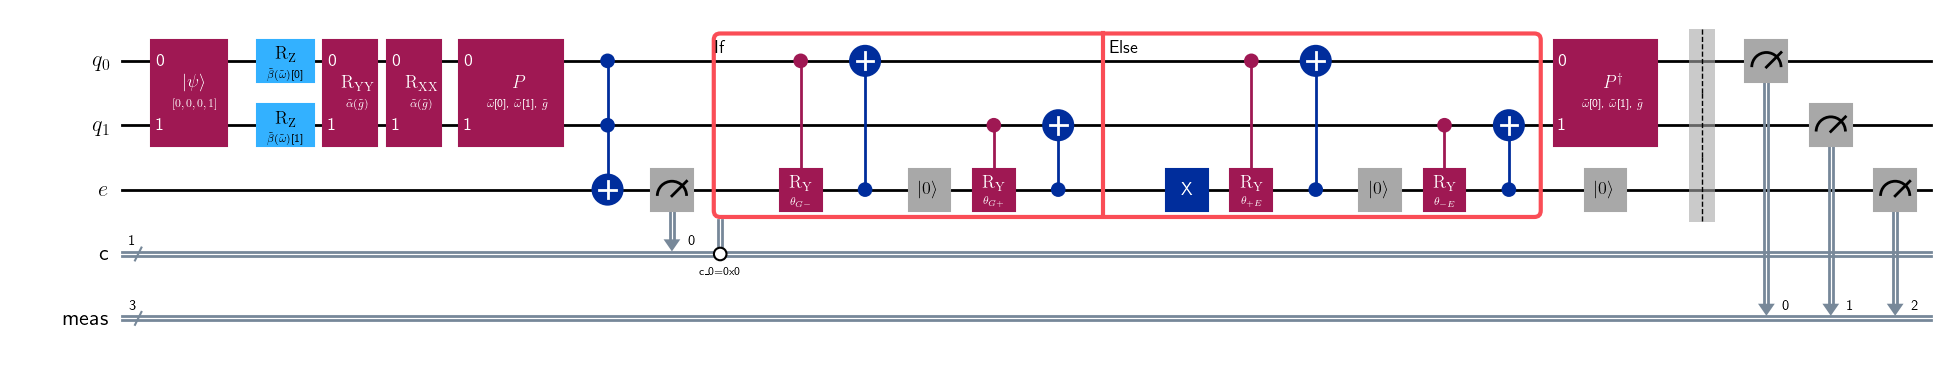

In [24]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 2
initial_state = [0]*(2**n)
initial_state[-1] = 1

system = QuantumRegister(n, name = 'q')
environment = QuantumRegister(math.trunc(n/2), 'e')
classical_bits = ClassicalRegister(n-1, name = 'c')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = Parameter('$\\tilde{g}$')

tilde_alpha = Parameter('$\\tilde{\\alpha} (\\tilde{g})$')
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

theta_g_plus = Parameter(r'$\theta_{G+}$')
theta_g_minus = Parameter(r'$\theta_{G−}$')
theta_minus_e = Parameter(r'$\theta_{−E}$')
theta_plus_e = Parameter(r'$\theta_{+E}$')


init = QuantumCircuit(system, environment, classical_bits)
initial_qubit_state = initial_state    
initial_statevector = Statevector(initial_qubit_state) 
init.initialize(params = initial_statevector, qubits = system, normalize = True)

qc = QuantumCircuit(system, environment, classical_bits)

# Free Hamiltonian evolution
for l in range(r):

    for i in range(n):

        qc.rz(tilde_beta[i], system[i])

    # Two-layer interaction circuit

    for j in range(0, n-1, 2):

        qc.ryy(tilde_alpha, qubit1 = system[j], qubit2 = system[j+1])
        qc.rxx(tilde_alpha, qubit1 = system[j], qubit2 = system[j+1])

# Decay

P_gate = Gate(name = 'P', params = [omega_eff[0], omega_eff[1], g_eff],num_qubits = 2, label = '$P$')
P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[0], omega_eff[1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')

counter = 0

for j in range(0, n-1, 2):

    qc.append(P_gate, [system[j], system[j+1]])
    
    qc.ccx(system[j], system[j+1], environment[counter])

    qc.measure(environment[counter], classical_bits[j])

    # Checking classically for correct parameter assignment

    with qc.if_test((classical_bits[j], 0)) as else_:

        qc.cry(theta_g_minus, system[j], environment[counter])
        qc.cx(environment[counter], system[j])
        qc.reset(environment[counter])
        qc.cry(theta_g_plus, system[j+1], environment[counter])               
        qc.cx(environment[counter], system[j+1])

    with else_:

        qc.x(environment[counter]) # To make it go back to 1.
        qc.cry(theta_plus_e, system[j], environment[counter])
        qc.cx(environment[counter], system[j])
        qc.reset(environment[counter])
        qc.cry(theta_minus_e, system[j+1], environment[counter])               
        qc.cx(environment[counter], system[j+1])


    qc.append(P_dag_gate, [system[j], system[j+1]])
    qc.reset(environment[counter])
    counter = counter + 1

parametrized_qc = (qc.compose(init, front = True))
parametrized_qc.measure_all()

a = parametrized_qc.draw('mpl', fold = 70)
a.savefig('figures/dynamic_circuit_v2')
a

In [25]:
from main_functions.gen_dynamic_circuit_v2 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = service.backend('ibm_marrakesh')
pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)

omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [2,3,4,5,6,7,8,9,10]

virtual_tqd = []
transpiled_tqd = []

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.8) for x in range(i)]
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
    g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[0] = 1

    sampler_qc = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r)

    decomposed_qc = sampler_qc.decompose(reps = 2)

    trans_qc = pm.run(decomposed_qc)

    virtual_tqd.append(get_circuit_properties(decomposed_qc)['two qubit depth'])
    transpiled_tqd.append(get_circuit_properties(trans_qc)['two qubit depth'])

    print(f'n = {i} done!')

df = pd.DataFrame({'n' : n_molecules, 'virtual circuit' : virtual_tqd, 'transpiled circuit' : transpiled_tqd})
df.to_csv('data/dynamic_circuit_v2_tqd_scaling.csv')

n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!


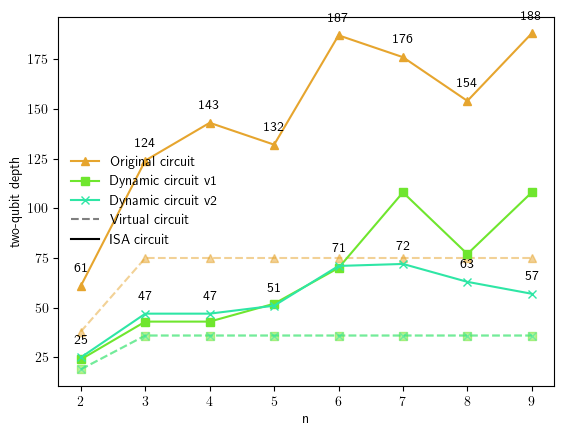

In [26]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_v2_data = pd.read_csv('data/dynamic_circuit_v2_tqd_scaling.csv')
dynamic_v1_data = pd.read_csv('data/dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/original_circuit_tqd_scaling.csv')

plottable_dynamic_v2 = dynamic_v2_data[dynamic_v2_data['n'] < 10]
plottable_dynamic_v1 = dynamic_v1_data[dynamic_v1_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]


colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[0], alpha = 0.5)
plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[0], label = 'Original circuit')
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['virtual circuit'], linestyle = 'dashed', marker = 's', color = colors[1], alpha = 0.5)
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['transpiled circuit'], linestyle = 'solid', marker = 's', color = colors[1], label = 'Dynamic circuit v1')
plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['virtual circuit'], linestyle = 'dashed', marker = 'x', color = colors[2], alpha = 0.5)
plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['transpiled circuit'], linestyle = 'solid', marker = 'x', color = colors[2], label = 'Dynamic circuit v2')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for i, txt in enumerate(plottable_original['transpiled circuit']):

    plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

#for i, txt in enumerate(plottable_dynamic_v1['transpiled circuit']):

    # plt.annotate(txt, (plottable_dynamic_v1['n'][i], plottable_dynamic_v1['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(plottable_dynamic_v2['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic_v2['n'][i], plottable_dynamic_v2['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/original_vs_dynamic_circuit_v1_vs_dynamic_circuit_v2_tqd_scaling.png', bbox_inches='tight')

## Combining the pairwise ancilla allocation with a tailored `initial_layout` (v3)


If not specified in the `PassManager`, different stochastic
 methods are used to find the layout that requires the least number of SWAP operations. For our circuit, however, we can specify a chain-like `initial_layout` that alternates pair of system qubits with their associated ancilla. For example, for $n=4$, this would be $q_0-q_1-e_0-q_2-q_3-e_1$. Since the circuit alternates between pairwise interaction between the system qubits and interactions of those qubits with their ancilla, this layout seems appropiate.

Qiskit already has an attribute of the `backend.properties()` method called `general_qlists` that returns lists containing the indeces of the 'best' physical qubits for a given chain length $n$. 'Best' in this context refers to a combination of least readout error and least CZ error. With this in mind, we have created the function `chain_initial_layout()` found in the `utils` folder. This function is used right after circuit creation to map the system and environment registers to the best physical qubit chain of a given backend.

In [27]:
from main_functions.gen_dynamic_circuit_v3 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = service.backend('ibm_marrakesh')


omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [2,3,4,5,6,7,8,9,10]

virtual_tqd = []
transpiled_tqd = []

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.8) for x in range(i)]
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
    g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[0] = 1

    sampler_qc, initial_layout = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r, backend)
    decomposed_qc = sampler_qc.decompose(reps = 2)

    pm = generate_preset_pass_manager(optimization_level = 3, backend = backend, initial_layout=initial_layout)
    trans_qc = pm.run(decomposed_qc)

    virtual_tqd.append(get_circuit_properties(decomposed_qc)['two qubit depth'])
    transpiled_tqd.append(get_circuit_properties(trans_qc)['two qubit depth'])

    print(f'n = {i} done!')

df = pd.DataFrame({'n' : n_molecules, 'virtual circuit' : virtual_tqd, 'transpiled circuit' : transpiled_tqd})
df.to_csv('data/dynamic_circuit_v3_tqd_scaling.csv')

n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!


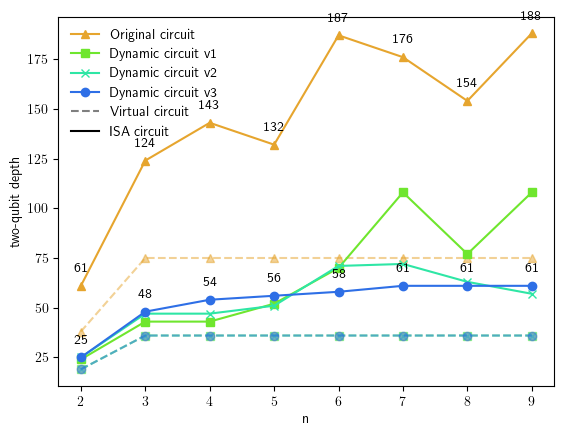

In [28]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_v3_data = pd.read_csv('data/dynamic_circuit_v3_tqd_scaling.csv')
dynamic_v2_data = pd.read_csv('data/dynamic_circuit_v2_tqd_scaling.csv')
dynamic_v1_data = pd.read_csv('data/dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/original_circuit_tqd_scaling.csv')

plottable_dynamic_v3 = dynamic_v3_data[dynamic_v3_data['n'] < 10]
plottable_dynamic_v2 = dynamic_v2_data[dynamic_v2_data['n'] < 10]
plottable_dynamic_v1 = dynamic_v1_data[dynamic_v1_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]


colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[0], alpha = 0.5)
plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[0], label = 'Original circuit')
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['virtual circuit'], linestyle = 'dashed', marker = 's', color = colors[1], alpha = 0.5)
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['transpiled circuit'], linestyle = 'solid', marker = 's', color = colors[1], label = 'Dynamic circuit v1')
plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['virtual circuit'], linestyle = 'dashed', marker = 'x', color = colors[2], alpha = 0.5)
plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['transpiled circuit'], linestyle = 'solid', marker = 'x', color = colors[2], label = 'Dynamic circuit v2')
plt.plot(plottable_dynamic_v3['n'], plottable_dynamic_v3['virtual circuit'], linestyle = 'dashed', marker = 'o', color = colors[3], alpha = 0.5)
plt.plot(plottable_dynamic_v3['n'], plottable_dynamic_v3['transpiled circuit'], linestyle = 'solid', marker = 'o', color = colors[3], label = 'Dynamic circuit v3')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for i, txt in enumerate(plottable_original['transpiled circuit']):

    plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')


for i, txt in enumerate(plottable_dynamic_v3['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic_v3['n'][i], plottable_dynamic_v3['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/original_vs_DCv1_vs_DCv2_vs_DCv3_tqd_scaling.png', bbox_inches='tight')

## Eficcient layering (v4)


For $n>2$, both the Hamiltonian interaction and the Lindbladian decay are modelled in a layer-like way for parallelization purposes. Although efficient in itself, this still requires many extra SWAP gates to be rightfully added to the circuit. To illustrate this, let's consider the most updated circuit we have right now (v3) for $n=4$. The interaction layer starts with the operations


\begin{align}
R_{XX} (q_0, q_1) R_{YY} (q_0, q_1) \otimes R_{XX} (q_2, q_3) R_{YY} (q_2, q_3) \left| \Psi \right> \equiv \left| \Psi' \right>
\end{align}

followed by 

\begin{align}
R_{XX} (q_1, q_2) R_{YY} (q_1, q_2) \left| \Psi' \right>
\end{align}

Before applying this second operation, a $SWAP$ operation needs to be performed already on qubits $q_1, e_0$ so that $q_1, q_2$ can interact. Additionally, the next operation is the decay $\epsilon_{01} (q_0, q_1) \otimes \epsilon_{23} (q_2,q_3)$, starting with the basis change gate $P (q_0,q_1) \otimes P(q_2, q_3)$, so we need to $SWAP$ back $q_1$ and $e_0$ so that $q_0$ and $q_1$ can interact. Right after this, another SWAP must be implemented to start the Toffoli gate. To sum up, the current distribution of the layers still requires many extra SWAPs to be added to the circuit. Nonetheless, this SWAP count can be reduced if we consider a more efficient distribution of the layers. In particular, we propose reordering operations qubitwise: instead of performing $R_{XX} (q_0, q_1) R_{YY} (q_0, q_1) \otimes R_{XX} (q_2, q_3) R_{YY} (q_2, q_3)$, followed by $R_{XX} (q_1, q_2) R_{YY} (q_1, q_2)$ and then $\epsilon_{01} (q_0,q_1)\otimes \epsilon_{23 }(q_2, q_3)$, followed by $\epsilon_{12} (q_1,q_2)$ (left side of the barrier of the circuit below), we perform $ R_{XX} (q_0, q_1) R_{YY} (q_0, q_1) \otimes R_{XX} (q_2, q_3) R_{YY} (q_2, q_3) \rightarrow \epsilon_{01} (q_0, q_1) \otimes \epsilon_{23} (q_2, q_3)$ followed by $R_{XX} (q_1, q_2) R_{YY} (q_1, q_2) \rightarrow \epsilon_{12} (q_1,q_2) $ (see right side of the circuit below). In other words, instead of performing both layers of interaction followed by both layers of decay, we group the first two of each and perform one right after the other, since they involve the same interacting qubits, and do the exact same with the second layers.


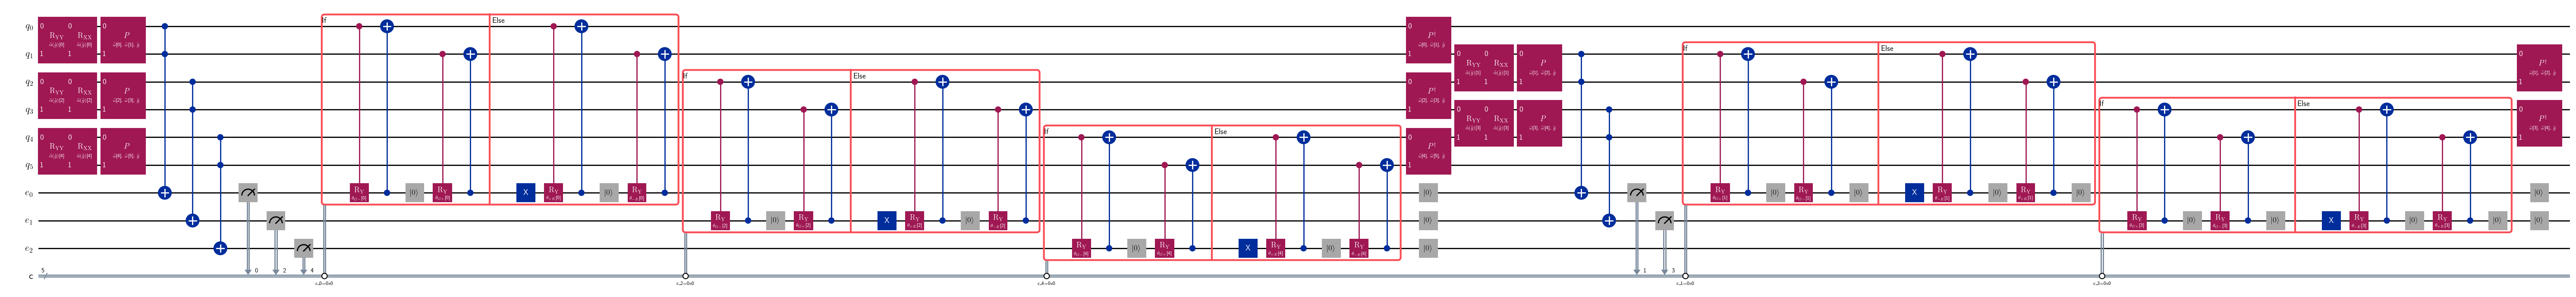

In [25]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 6

system = QuantumRegister(n, 'q')
environment = QuantumRegister(math.trunc(n/2), 'e')
classical_bits = ClassicalRegister(n-1, name = 'c')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = Parameter('$\\tilde{g}$')

tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', n-1)
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

theta_g_plus = ParameterVector(r'$\theta_{G+}$', n-1)
theta_g_minus = ParameterVector(r'$\theta_{G−}$', n-1)
theta_minus_e = ParameterVector(r'$\theta_{−E}$', n-1)
theta_plus_e = ParameterVector(r'$\theta_{+E}$', n-1)

qc = QuantumCircuit(system, environment, classical_bits)

# Two-layer interaction circuit

# for j in range(0, n-1, 2):

#     qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
#     qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

# if n > 2:

#     counter = 0

#     for j in range(1, n-1, 2):

#         qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
#         qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

# # Decay

# counter = 0

# for j in range(0, n-1, 2):

#     P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff],num_qubits = 2, label = '$P$')
#     P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')

#     qc.append(P_gate, [system[j], system[j+1]])
#     qc.ccx(system[j], system[j+1], environment[counter])
#     qc.measure(environment[counter], classical_bits[j])

#     # Checking classically for correct parameter assignment

#     with qc.if_test((classical_bits[j], 0)) as else_:

#         qc.cry(theta_g_minus[j], system[j], environment[counter])
#         qc.cx(environment[counter], system[j])
#         qc.reset(environment[counter])
#         qc.cry(theta_g_plus[j], system[j+1], environment[counter])               
#         qc.cx(environment[counter], system[j+1])

#     with else_:

#         qc.x(environment[counter]) # To make it go back to 1.
#         qc.cry(theta_plus_e[j], system[j], environment[counter])
#         qc.cx(environment[counter], system[j])
#         qc.reset(environment[counter])
#         qc.cry(theta_minus_e[j], system[j+1], environment[counter])               
#         qc.cx(environment[counter], system[j+1])


#     qc.append(P_dag_gate, [system[j], system[j+1]])
#     qc.reset(environment[counter])
#     counter = counter + 1

# if n > 2:

#     counter = 0

#     for j in range(1, n-1, 2):

#         P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff],num_qubits = 2, label = '$P$')
#         P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')
        
#         qc.append(P_gate, [system[j], system[j+1]])
#         qc.ccx(system[j], system[j+1], environment[counter])
#         qc.measure(environment[counter], classical_bits[j])

#         # Checking classically for correct parameter assignment

#         with qc.if_test((classical_bits[j], 0)) as else_:

#             qc.cry(theta_g_plus[j], system[j], environment[counter])
#             qc.cx(environment[counter], system[j]) 
#             qc.reset(environment[counter])
#             qc.cry(theta_g_minus[j], system[j+1], environment[counter]) 
#             qc.cx(environment[counter], system[j+1])
#             qc.reset(environment[counter])

#         with else_:

#             qc.x(environment[counter]) # To make it go back to 1.
#             qc.cry(theta_minus_e[j], system[j], environment[counter])
#             qc.cx(environment[counter], system[j])
#             qc.reset(environment[counter])
#             qc.cry(theta_plus_e[j], system[j+1], environment[counter])
#             qc.cx(environment[counter], system[j+1])
#             qc.reset(environment[counter])


#         qc.append(P_dag_gate, [system[j], system[j+1]])
#         qc.reset(environment[counter])

#         counter = counter + 1

# qc.barrier()
# ################################################################################################################################################

counter = 0

for j in range(0, n-1, 2):

    qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
    qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

    P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff],num_qubits = 2, label = '$P$')
    P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')

    qc.append(P_gate, [system[j], system[j+1]])
    qc.ccx(system[j], system[j+1], environment[counter])
    qc.measure(environment[counter], classical_bits[j])

    # Checking classically for correct parameter assignment

    with qc.if_test((classical_bits[j], 0)) as else_:

        qc.cry(theta_g_minus[j], system[j], environment[counter])
        qc.cx(environment[counter], system[j])
        qc.reset(environment[counter])
        qc.cry(theta_g_plus[j], system[j+1], environment[counter])               
        qc.cx(environment[counter], system[j+1])

    with else_:

        qc.x(environment[counter]) # To make it go back to 1.
        qc.cry(theta_plus_e[j], system[j], environment[counter])
        qc.cx(environment[counter], system[j])
        qc.reset(environment[counter])
        qc.cry(theta_minus_e[j], system[j+1], environment[counter])               
        qc.cx(environment[counter], system[j+1])


    qc.append(P_dag_gate, [system[j], system[j+1]])
    qc.reset(environment[counter])
    counter = counter + 1

if n > 2:

    counter = 0

    for j in range(1, n-1, 2):

        qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
        qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

        P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff],num_qubits = 2, label = '$P$')
        P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')
        
        qc.append(P_gate, [system[j], system[j+1]])
        qc.ccx(system[j], system[j+1], environment[counter])
        qc.measure(environment[counter], classical_bits[j])

        # Checking classically for correct parameter assignment

        with qc.if_test((classical_bits[j], 0)) as else_:

            qc.cry(theta_g_plus[j], system[j], environment[counter])
            qc.cx(environment[counter], system[j]) 
            qc.reset(environment[counter])
            qc.cry(theta_g_minus[j], system[j+1], environment[counter]) 
            qc.cx(environment[counter], system[j+1])
            qc.reset(environment[counter])

        with else_:

            qc.x(environment[counter]) # To make it go back to 1.
            qc.cry(theta_minus_e[j], system[j], environment[counter])
            qc.cx(environment[counter], system[j])
            qc.reset(environment[counter])
            qc.cry(theta_plus_e[j], system[j+1], environment[counter])
            qc.cx(environment[counter], system[j+1])
            qc.reset(environment[counter])


        qc.append(P_dag_gate, [system[j], system[j+1]])
        qc.reset(environment[counter])

        counter = counter + 1

a = qc.draw('mpl', fold = -1)
a.savefig('figures/dynamic_circuit_v4_6_emitters_fully_folded.png',  transparent=True)
a

Since we are essentially changing the $R_{XX} (q_1, q_2) R_{YY} (q_1, q_2)$ layer with $\epsilon_{01} (q_0,q_1)\otimes \epsilon_{23 }(q_2, q_3)$ (second interaction layer with the first decay layer), this approach would only work if $\exp(H_{int}^{(12)})$ commutes with $\varepsilon_{01} \otimes \varepsilon_{23}$

NOTE TO SELF: You have to find a way to prove the idea above.

In [29]:
from main_functions.gen_dynamic_circuit_v4 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = service.backend('ibm_marrakesh')


omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [2,3,4,5,6,7,8,9,10]

virtual_tqd = []
transpiled_tqd = []

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.8) for x in range(i)]
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
    g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[0] = 1

    sampler_qc, initial_layout = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r, backend)
    decomposed_qc = sampler_qc.decompose(reps = 2)

    pm = generate_preset_pass_manager(optimization_level = 3, backend = backend, initial_layout=initial_layout)
    trans_qc = pm.run(decomposed_qc)

    virtual_tqd.append(get_circuit_properties(decomposed_qc)['two qubit depth'])
    transpiled_tqd.append(get_circuit_properties(trans_qc)['two qubit depth'])

    print(f'n = {i} done!')

df = pd.DataFrame({'n' : n_molecules, 'virtual circuit' : virtual_tqd, 'transpiled circuit' : transpiled_tqd})
df.to_csv('data/dynamic_circuit_v4_tqd_scaling.csv')

n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!


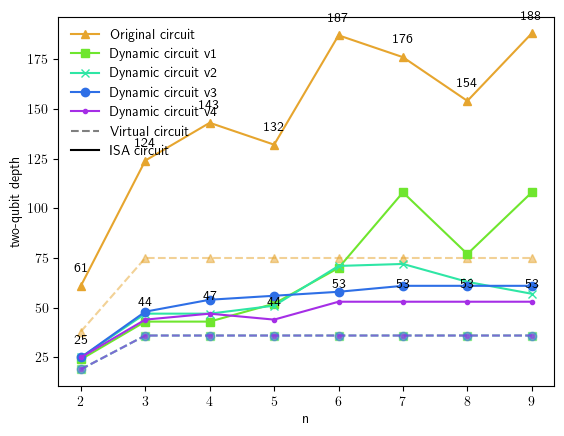

In [30]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_v4_data = pd.read_csv('data/dynamic_circuit_v4_tqd_scaling.csv')
dynamic_v3_data = pd.read_csv('data/dynamic_circuit_v3_tqd_scaling.csv')
dynamic_v2_data = pd.read_csv('data/dynamic_circuit_v2_tqd_scaling.csv')
dynamic_v1_data = pd.read_csv('data/dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/original_circuit_tqd_scaling.csv')

plottable_dynamic_v4 = dynamic_v4_data[dynamic_v4_data['n'] < 10]
plottable_dynamic_v3 = dynamic_v3_data[dynamic_v3_data['n'] < 10]
plottable_dynamic_v2 = dynamic_v2_data[dynamic_v2_data['n'] < 10]
plottable_dynamic_v1 = dynamic_v1_data[dynamic_v1_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]


colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[0], alpha = 0.5)
plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[0], label = 'Original circuit')
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['virtual circuit'], linestyle = 'dashed', marker = 's', color = colors[1], alpha = 0.5)
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['transpiled circuit'], linestyle = 'solid', marker = 's', color = colors[1], label = 'Dynamic circuit v1')
plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['virtual circuit'], linestyle = 'dashed', marker = 'x', color = colors[2], alpha = 0.5)
plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['transpiled circuit'], linestyle = 'solid', marker = 'x', color = colors[2], label = 'Dynamic circuit v2')
plt.plot(plottable_dynamic_v3['n'], plottable_dynamic_v3['virtual circuit'], linestyle = 'dashed', marker = 'o', color = colors[3], alpha = 0.5)
plt.plot(plottable_dynamic_v3['n'], plottable_dynamic_v3['transpiled circuit'], linestyle = 'solid', marker = 'o', color = colors[3], label = 'Dynamic circuit v3')
plt.plot(plottable_dynamic_v4['n'], plottable_dynamic_v4['virtual circuit'], linestyle = 'dashed', marker = '.', color = colors[4], alpha = 0.5)
plt.plot(plottable_dynamic_v4['n'], plottable_dynamic_v4['transpiled circuit'], linestyle = 'solid', marker = '.', color = colors[4], label = 'Dynamic circuit v4')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for i, txt in enumerate(plottable_original['transpiled circuit']):

    plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')


for i, txt in enumerate(plottable_dynamic_v4['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic_v4['n'][i], plottable_dynamic_v4['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/original_vs_DCv1_vs_DCv2_vs_DCv3_vs_DCv4_tqd_scaling.png', bbox_inches='tight')

## Introducing SWAP layering (v5)

Everything we have done up until this point on every version of `gen_dynamic_circuit` is trying to reduce the circuit depth of the previous version by applying problem-specific knowledge onto the circuit (pairwise ancilla allocation, commutation of layers, tailored initial layout, etc.). One last specification that we can provide the transpiler is explicitly specifying in the virtual circuit when the SWAP operations must occur, so that no `routing` needs to be done and we ensure that no unnecessary SWAP operations are being added by the transpiler.

The insertion of these SWAPs require both a decomposition of the Toffolis into simpler gates (to identify when must be SWAP) and an overall redirection of the operations after swapping. This is all introduced in the file `gen_dynamic_circuit_v5.py`.

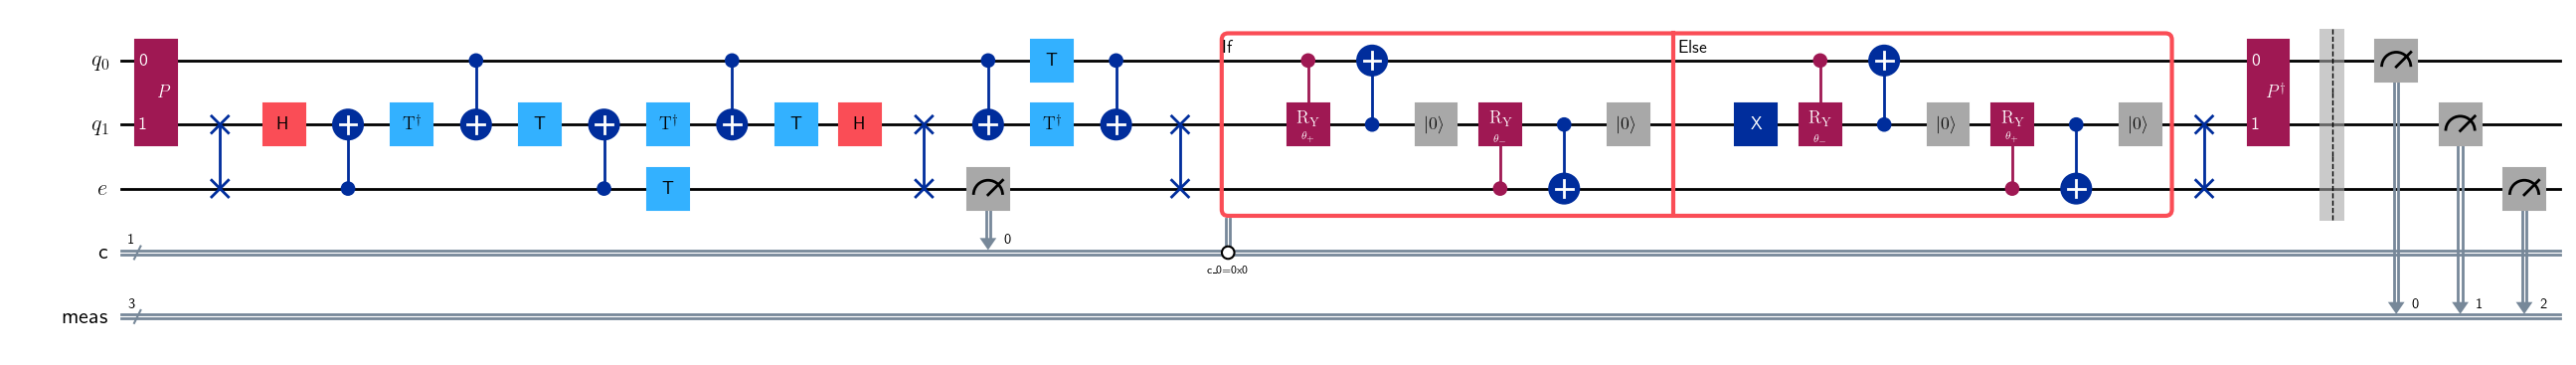

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

n = 2

system = QuantumRegister(n, 'q')
environment = QuantumRegister(math.trunc(n/2), 'e')
classical_bits = ClassicalRegister(n-1, name = 'c')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = Parameter('$\\tilde{g}$')

tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', n-1)
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

# theta_g_plus = ParameterVector(r'$\theta_{G+}$', n-1)
# theta_g_minus = ParameterVector(r'$\theta_{G−}$', n-1)
# theta_minus_e = ParameterVector(r'$\theta_{−E}$', n-1)
# theta_plus_e = ParameterVector(r'$\theta_{+E}$', n-1)

theta_g_plus = Parameter(r'$\theta_{+}$')
theta_g_minus = Parameter(r'$\theta_{−}$')
theta_minus_e = theta_g_minus
theta_plus_e = theta_g_plus

qc = QuantumCircuit(system, environment, classical_bits)

counter = 0

# for i in range(n):

    # qc.rz(tilde_beta[i], system[i])

for j in range(0, n-1, 2):

    # qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
    # qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

    # P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff],num_qubits = 2, label = '$P$')
    # P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')

    P_gate = Gate(name = 'P', params = [],num_qubits = 2, label = '$P$')
    P_dag_gate = Gate(name = 'Pdag', params = [], num_qubits = 2, label = '$P^{\\dag}$')

    qc.append(P_gate, [system[j], system[j+1]])

    qc.swap(system[j+1], environment[counter])

    qc.h(system[j+1])
    qc.cx(environment[counter], system[j+1])
    qc.tdg(system[j+1])
    qc.cx(system[j], system[j+1])
    qc.t(system[j+1])
    qc.cx(environment[counter], system[j+1])
    qc.tdg(system[j+1])
    qc.t(environment[counter])
    qc.cx(system[j], system[j+1])
    qc.t(system[j+1])
    qc.h(system[j+1])

    qc.swap(system[j+1], environment[counter])

    qc.cx(system[j], system[j+1])
    qc.t(system[j])
    qc.tdg(system[j+1])
    qc.cx(system[j], system[j+1])
    
    qc.measure(environment[counter], classical_bits[j])

    qc.swap(system[j+1], environment[counter])

    # Checking classically for correct parameter assignment

    with qc.if_test((classical_bits[j], 0)) as else_:

        # qc.cry(theta_g_plus[j], system[j], system[j+1])
        qc.cry(theta_g_plus, system[j], system[j+1])
        qc.cx(system[j+1], system[j]) 
        qc.reset(system[j+1])
        # qc.cry(theta_g_minus[j], environment[counter], system[j+1]) 
        qc.cry(theta_g_minus, environment[counter], system[j+1])
        qc.cx(system[j+1], environment[counter])
        qc.reset(system[j+1])

    with else_:

        qc.x(system[j+1]) # To make it go back to 1.
        # qc.cry(theta_minus_e[j], system[j], system[j+1])
        qc.cry(theta_minus_e, system[j], system[j+1])
        qc.cx(system[j+1], system[j])
        qc.reset(system[j+1])
        # qc.cry(theta_plus_e[j], environment[counter], system[j+1])
        qc.cry(theta_plus_e, environment[counter], system[j+1])
        qc.cx(system[j+1], environment[counter])
        qc.reset(system[j+1])

    qc.swap(system[j+1], environment[counter])

    qc.append(P_dag_gate, [system[j], system[j+1]])
    # qc.reset(environment[counter])
    counter = counter + 1

if n > 2:

    counter = 0

    for j in range(1, n-1, 2):

        qc.swap(system[j], environment[counter])

        qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = environment[counter])
        qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = environment[counter])

        P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff],num_qubits = 2, label = '$P$')
        P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff], num_qubits = 2, label = '$P^{\\dag}$')
        
        qc.append(P_gate, [system[j], environment[counter]])

        qc.swap(system[j], environment[counter])

        qc.h(environment[counter])
        qc.cx(system[j+1], environment[counter])
        qc.tdg(environment[counter])
        qc.cx(system[j], environment[counter])
        qc.t(environment[counter])
        qc.cx(system[j+1], environment[counter])
        qc.tdg(environment[counter])
        qc.t(system[j+1])
        qc.cx(system[j], environment[counter])
        qc.t(environment[counter])
        qc.h(environment[counter])

        qc.swap(system[j], environment[counter])

        qc.cx(system[j], environment[counter])
        qc.t(system[j])
        qc.tdg(environment[counter])
        qc.cx(system[j], environment[counter])

        qc.measure(system[j], classical_bits[j])

        qc.swap(system[j], environment[counter])

        # Checking classically for correct parameter assignment

        with qc.if_test((classical_bits[j], 0)) as else_:

            qc.cry(theta_g_plus[j], system[j], environment[counter])
            qc.cx(environment[counter], system[j]) 
            qc.reset(environment[counter])
            qc.cry(theta_g_minus[j], system[j+1], environment[counter]) 
            qc.cx(environment[counter], system[j+1])
            qc.reset(environment[counter])

        with else_:

            qc.x(environment[counter]) # To make it go back to 1.
            qc.cry(theta_minus_e[j], system[j], environment[counter])
            qc.cx(environment[counter], system[j])
            qc.reset(environment[counter])
            qc.cry(theta_plus_e[j], system[j+1], environment[counter])
            qc.cx(environment[counter], system[j+1])
            qc.reset(environment[counter])

        qc.swap(system[j], environment[counter])

        qc.append(P_dag_gate, [system[j], environment[counter]])
        #qc.reset(environment[counter])

        qc.swap(system[j], environment[counter])

        counter = counter + 1

qc.measure_all()

a = qc.draw('mpl', fold = 60)
a.savefig('figures/kkk.png', bbox_inches = 'tight', transparent = True)
a

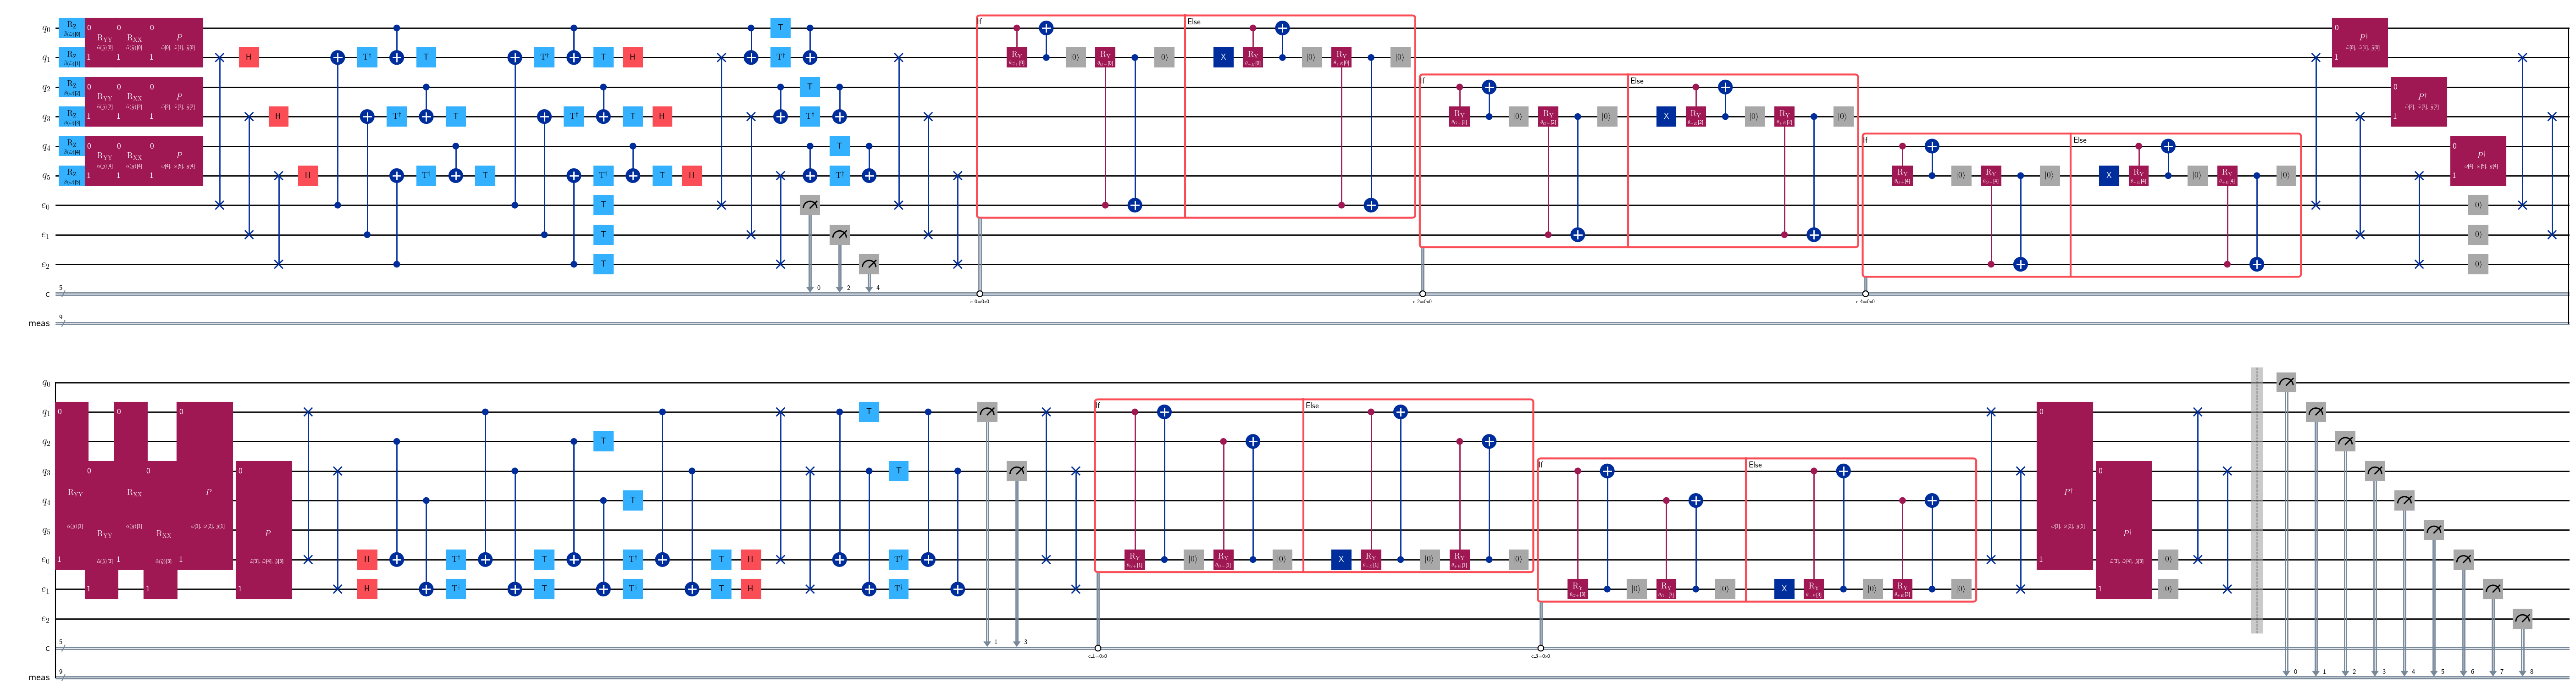

In [4]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 500

n = 6

system = QuantumRegister(n, 'q')
environment = QuantumRegister(math.trunc(n/2), 'e')
classical_bits = ClassicalRegister(n-1, name = 'c')

omega_eff = ParameterVector('$\\tilde{\\omega}$', n)
g_eff = ParameterVector('$\\tilde{g}$', n-1)

tilde_alpha = ParameterVector('$\\tilde{\\alpha} (\\tilde{g})$', n-1)
tilde_beta = ParameterVector('$\\tilde{\\beta} (\\tilde{\\omega})$', n)

theta_g_plus = ParameterVector(r'$\theta_{G+}$', n-1)
theta_g_minus = ParameterVector(r'$\theta_{G−}$', n-1)
theta_minus_e = ParameterVector(r'$\theta_{−E}$', n-1)
theta_plus_e = ParameterVector(r'$\theta_{+E}$', n-1)

qc = QuantumCircuit(system, environment, classical_bits)

counter = 0

for i in range(n):

    qc.rz(tilde_beta[i], system[i])

for j in range(0, n-1, 2):

    qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])
    qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = system[j+1])

    P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff[j]],num_qubits = 2, label = '$P$')
    P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P^{\\dag}$')

    qc.append(P_gate, [system[j], system[j+1]])

    qc.swap(system[j+1], environment[counter])

    qc.h(system[j+1])
    qc.cx(environment[counter], system[j+1])
    qc.tdg(system[j+1])
    qc.cx(system[j], system[j+1])
    qc.t(system[j+1])
    qc.cx(environment[counter], system[j+1])
    qc.tdg(system[j+1])
    qc.t(environment[counter])
    qc.cx(system[j], system[j+1])
    qc.t(system[j+1])
    qc.h(system[j+1])

    qc.swap(system[j+1], environment[counter])

    qc.cx(system[j], system[j+1])
    qc.t(system[j])
    qc.tdg(system[j+1])
    qc.cx(system[j], system[j+1])
    
    qc.measure(environment[counter], classical_bits[j])

    qc.swap(system[j+1], environment[counter])

    # Checking classically for correct parameter assignment

    with qc.if_test((classical_bits[j], 0)) as else_:

        qc.cry(theta_g_plus[j], system[j], system[j+1])
        qc.cx(system[j+1], system[j]) 
        qc.reset(system[j+1])
        qc.cry(theta_g_minus[j], environment[counter], system[j+1]) 
        qc.cx(system[j+1], environment[counter])
        qc.reset(system[j+1])

    with else_:

        qc.x(system[j+1]) # To make it go back to 1.
        qc.cry(theta_minus_e[j], system[j], system[j+1])
        qc.cx(system[j+1], system[j])
        qc.reset(system[j+1])
        qc.cry(theta_plus_e[j], environment[counter], system[j+1])
        qc.cx(system[j+1], environment[counter])
        qc.reset(system[j+1])

    qc.swap(system[j+1], environment[counter])

    qc.append(P_dag_gate, [system[j], system[j+1]])
    qc.reset(environment[counter])
    counter = counter + 1

if n > 2:

    counter = 0

    for j in range(1, n-1, 2):

        qc.swap(system[j], environment[counter])

        qc.ryy(tilde_alpha[j], qubit1 = system[j], qubit2 = environment[counter])
        qc.rxx(tilde_alpha[j], qubit1 = system[j], qubit2 = environment[counter])

        P_gate = Gate(name = 'P', params = [omega_eff[j], omega_eff[j+1], g_eff[j]],num_qubits = 2, label = '$P$')
        P_dag_gate = Gate(name = 'Pdag', params = [omega_eff[j], omega_eff[j+1], g_eff[j]], num_qubits = 2, label = '$P^{\\dag}$')
        
        qc.append(P_gate, [system[j], environment[counter]])

        qc.swap(system[j], environment[counter])

        qc.h(environment[counter])
        qc.cx(system[j+1], environment[counter])
        qc.tdg(environment[counter])
        qc.cx(system[j], environment[counter])
        qc.t(environment[counter])
        qc.cx(system[j+1], environment[counter])
        qc.tdg(environment[counter])
        qc.t(system[j+1])
        qc.cx(system[j], environment[counter])
        qc.t(environment[counter])
        qc.h(environment[counter])

        qc.swap(system[j], environment[counter])

        qc.cx(system[j], environment[counter])
        qc.t(system[j])
        qc.tdg(environment[counter])
        qc.cx(system[j], environment[counter])

        qc.measure(system[j], classical_bits[j])

        qc.swap(system[j], environment[counter])

        # Checking classically for correct parameter assignment

        with qc.if_test((classical_bits[j], 0)) as else_:

            qc.cry(theta_g_plus[j], system[j], environment[counter])
            qc.cx(environment[counter], system[j]) 
            qc.reset(environment[counter])
            qc.cry(theta_g_minus[j], system[j+1], environment[counter]) 
            qc.cx(environment[counter], system[j+1])
            qc.reset(environment[counter])

        with else_:

            qc.x(environment[counter]) # To make it go back to 1.
            qc.cry(theta_minus_e[j], system[j], environment[counter])
            qc.cx(environment[counter], system[j])
            qc.reset(environment[counter])
            qc.cry(theta_plus_e[j], system[j+1], environment[counter])
            qc.cx(environment[counter], system[j+1])
            qc.reset(environment[counter])

        qc.swap(system[j], environment[counter])

        qc.append(P_dag_gate, [system[j], environment[counter]])
        qc.reset(environment[counter])

        qc.swap(system[j], environment[counter])

        counter = counter + 1

qc.measure_all()

a = qc.draw('mpl', fold = 85)
a.savefig(f'figures/dynamic_circuit_v5_{n}_qubits', bbox_inches = 'tight')
a

In [17]:
from main_functions.gen_dynamic_circuit_v5 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd
from qiskit.circuit import IfElseOp

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = service.backend('ibm_fez')
backend.refresh()  # <--- this will refresh the backend data
backend.target.add_instruction(IfElseOp, name="if_else")


omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [2,3,4,5,6,7,8,9,10]

virtual_tqd = []
transpiled_tqd = []

for i in n_molecules:

    omega_m = [ np.random.uniform(1, 1.5) for x in range(i)]
    gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
    g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
    initial_state = [0]*(2**i)
    initial_state[-1] = 1

    sampler_qc, initial_layout = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r, backend)
    decomposed_qc = sampler_qc.decompose(reps = 2)

    pm = generate_preset_pass_manager(optimization_level = 3, backend = backend, initial_layout=initial_layout, routing_method = 'none')
    trans_qc = pm.run(sampler_qc)

    virtual_tqd.append(get_circuit_properties(decomposed_qc)['two qubit depth'])
    transpiled_tqd.append(get_circuit_properties(trans_qc)['two qubit depth'])

    print(f'n = {i} done!')

df = pd.DataFrame({'n' : n_molecules, 'virtual circuit' : virtual_tqd, 'transpiled circuit' : transpiled_tqd})
df.to_csv('data/updated_06_12_fez_dynamic_circuit_v5_tqd_scaling_no_routing.csv')

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_26560\2637823307.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!


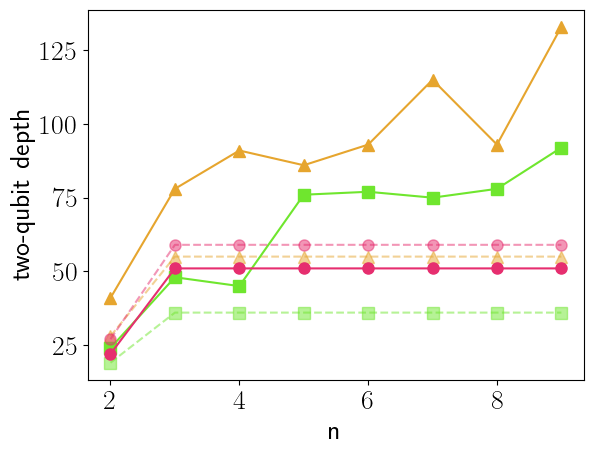

In [2]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
import pandas as pd
import numpy as np
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'font.size': 20})

dynamic_v5_data = pd.read_csv('data/updated_06_12_fez_dynamic_circuit_v5_tqd_scaling_no_routing.csv')
# dynamic_v4_data = pd.read_csv('data/dynamic_circuit_v4_tqd_scaling.csv')
# dynamic_v3_data = pd.read_csv('data/dynamic_circuit_v3_tqd_scaling.csv')
# dynamic_v2_data = pd.read_csv('data/dynamic_circuit_v2_tqd_scaling.csv')
dynamic_v1_data = pd.read_csv('data/updated_06_12_fez_dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/updated_06_12_marrakesh_original_circuit_tqd_scaling.csv')

plottable_dynamic_v5= dynamic_v5_data[dynamic_v5_data['n'] < 10]
# plottable_dynamic_v4 = dynamic_v4_data[dynamic_v4_data['n'] < 10]
# plottable_dynamic_v3 = dynamic_v3_data[dynamic_v3_data['n'] < 10]
# plottable_dynamic_v2 = dynamic_v2_data[dynamic_v2_data['n'] < 10]
plottable_dynamic_v1 = dynamic_v1_data[dynamic_v1_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]


colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', markersize = 8, color = colors[0], alpha = 0.5)
plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', markersize = 8, color = colors[0])
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['virtual circuit'], linestyle = 'dashed', marker = 's', markersize = 8, color = colors[1], alpha = 0.5)
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['transpiled circuit'], linestyle = 'solid', marker = 's', markersize = 8, color = colors[1])
# plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['virtual circuit'], linestyle = 'dashed', marker = 'x', color = colors[2], alpha = 0.5)
# plt.plot(plottable_dynamic_v2['n'], plottable_dynamic_v2['transpiled circuit'], linestyle = 'solid', marker = 'x', color = colors[2], label = 'Dynamic circuit v2')
# plt.plot(plottable_dynamic_v3['n'], plottable_dynamic_v3['virtual circuit'], linestyle = 'dashed', marker = 'o', color = colors[3], alpha = 0.5)
# plt.plot(plottable_dynamic_v3['n'], plottable_dynamic_v3['transpiled circuit'], linestyle = 'solid', marker = 'o', color = colors[3], label = 'Dynamic circuit v3')
# plt.plot(plottable_dynamic_v4['n'], plottable_dynamic_v4['virtual circuit'], linestyle = 'dashed', marker = '.', color = colors[4], alpha = 0.5)
# plt.plot(plottable_dynamic_v4['n'], plottable_dynamic_v4['transpiled circuit'], linestyle = 'solid', marker = '.', color = colors[4], label = 'Dynamic circuit v4')
plt.plot(plottable_dynamic_v5['n'], plottable_dynamic_v5['virtual circuit'], linestyle = 'dashed', marker = 'o', markersize = 8, color = colors[5], alpha = 0.5)
plt.plot(plottable_dynamic_v5['n'], plottable_dynamic_v5['transpiled circuit'], linestyle = 'solid', marker = 'o', markersize = 8, color = colors[5])

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Before transpilation')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'After transpilation')

# for i, txt in enumerate(plottable_original['transpiled circuit']):

#     plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')


# for i, txt in enumerate(plottable_dynamic_v5['transpiled circuit']):

#     plt.annotate(txt, (plottable_dynamic_v5['n'][i], plottable_dynamic_v5['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

#plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
#plt.savefig('figures/fig3a.png', bbox_inches='tight')
plt.savefig('keiki', bbox_inches='tight')

+ gordo todo

After all these versions, the overall scaling of the transpiled circuit is almost constant with the number of qubits, with a depth much lower than the one in both the virtual and transpiled circuits of the original version.

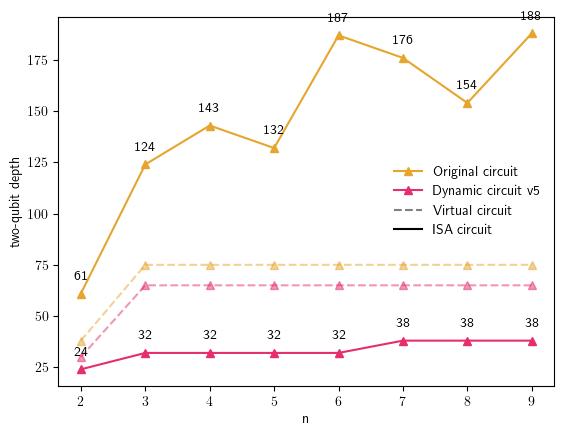

In [8]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_v5_data = pd.read_csv('data/dynamic_circuit_v5_tqd_scaling.csv')
original_data = pd.read_csv('data/original_circuit_tqd_scaling.csv')

plottable_dynamic_v5= dynamic_v5_data[dynamic_v5_data['n'] < 10]
plottable_original = original_data[original_data['n'] < 10]

colors = generate_complementary_colors(6, 'default', 'orange')

plt.plot(plottable_original['n'], plottable_original['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[0], alpha = 0.5)
plt.plot(plottable_original['n'], plottable_original['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[0], label = 'Original circuit')
plt.plot(plottable_dynamic_v5['n'], plottable_dynamic_v5['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[5], alpha = 0.5)
plt.plot(plottable_dynamic_v5['n'], plottable_dynamic_v5['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[5], label = 'Dynamic circuit v5')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for i, txt in enumerate(plottable_original['transpiled circuit']):

    plt.annotate(txt, (plottable_original['n'][i], plottable_original['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(plottable_dynamic_v5['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic_v5['n'][i], plottable_dynamic_v5['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/original_vs_DCv5_tqd_scaling.png', bbox_inches='tight')

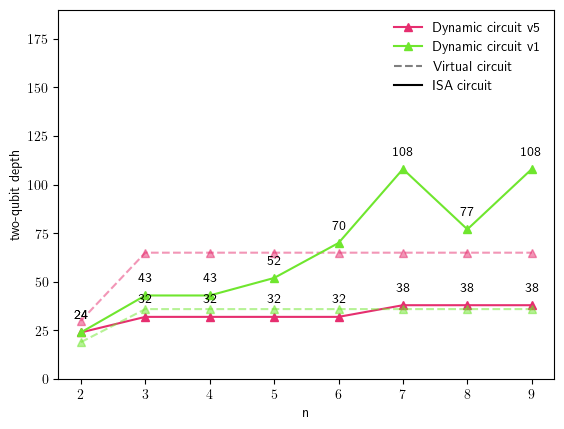

In [7]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

dynamic_v5_data = pd.read_csv('data/dynamic_circuit_v5_tqd_scaling.csv')
dynamic_v1_data = pd.read_csv('data/dynamic_circuit_v1_tqd_scaling.csv')
original_data = pd.read_csv('data/original_circuit_tqd_scaling.csv')

plottable_dynamic_v1= dynamic_v1_data[dynamic_v1_data['n'] < 10]
plottable_dynamic_v5= dynamic_v5_data[dynamic_v5_data['n'] < 10]

colors = generate_complementary_colors(6, 'default', 'orange')


plt.plot(plottable_dynamic_v5['n'], plottable_dynamic_v5['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[5], alpha = 0.5)
plt.plot(plottable_dynamic_v5['n'], plottable_dynamic_v5['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[5], label = 'Dynamic circuit v5')
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['virtual circuit'], linestyle = 'dashed', marker = '^', color = colors[1], alpha = 0.5)
plt.plot(plottable_dynamic_v1['n'], plottable_dynamic_v1['transpiled circuit'], linestyle = 'solid', marker = '^', color = colors[1], label = 'Dynamic circuit v1')

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for i, txt in enumerate(plottable_dynamic_v1['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic_v1['n'][i], plottable_dynamic_v1['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(plottable_dynamic_v5['transpiled circuit']):

    plt.annotate(txt, (plottable_dynamic_v5['n'][i], plottable_dynamic_v5['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(frameon=False)
plt.ylim([0,190])
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.savefig('figures/DCv1_vs_DCv5_tqd_scaling.png', bbox_inches='tight')

## Further study: inconsistencies in the ISA circuit tqd scaling

For example, from 6 to 7 emitters, the ISA circuit two-qubit depth makes a jump that should not happen in principle (with our approach)

In [ ]:
from main_functions.gen_dynamic_circuit_v5 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh, FakeSherbrooke
import pandas as pd

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

#backend = service.backend('ibm_marrakesh')
#backend = FakeMarrakesh()
#backend.refresh(service)
backend = FakeSherbrooke()

omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
n_molecules = [x for x in range(2, 20,1)]

qcs = []
routing_methods = ['none', 'preset']
data = { x : { 'n' : [], 'virtual circuit' : [], 'transpiled circuit' : [] } for x in routing_methods }
for rout in routing_methods:
    for i in n_molecules:
        omega_m = [ np.random.uniform(1, 1.5) for x in range(i)]
        gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
        g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
        initial_state = [0]*(2**i)
        initial_state[-1] = 1

        sampler_qc, initial_layout = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r, backend)
        decomposed_qc = sampler_qc.decompose(reps = 2)
        if rout == 'none':
            pm = generate_preset_pass_manager(optimization_level = 2, backend = backend, initial_layout=initial_layout, routing_method='none')
        else:
            pm = generate_preset_pass_manager(optimization_level = 3, backend = backend, initial_layout=initial_layout)

        trans_qc = pm.run(sampler_qc)
        qcs.append(trans_qc)
        print(f'n = {i} done!')
        data[rout]['virtual circuit'].append(get_circuit_properties(decomposed_qc)['two qubit depth'])
        data[rout]['transpiled circuit'].append(get_circuit_properties(trans_qc)['two qubit depth'])

    data[rout]['n'] = n_molecules

df = pd.DataFrame(data)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9128\1294152567.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!
n = 11 done!
n = 12 done!
n = 13 done!
n = 14 done!
n = 15 done!
n = 16 done!
n = 17 done!
n = 18 done!
n = 19 done!
n = 2 done!
n = 3 done!
n = 4 done!
n = 5 done!
n = 6 done!
n = 7 done!
n = 8 done!
n = 9 done!
n = 10 done!
n = 11 done!
n = 12 done!
n = 13 done!
n = 14 done!
n = 15 done!
n = 16 done!
n = 17 done!
n = 18 done!
n = 19 done!


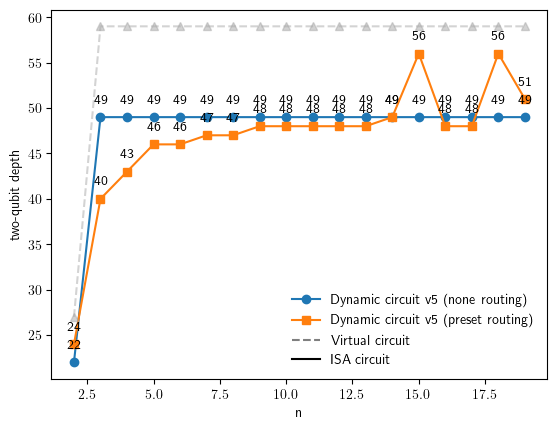

In [16]:
import matplotlib.pyplot as plt
from utils.generate_complementary_colors import generate_complementary_colors
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

colors = generate_complementary_colors(6, 'default', 'orange')

markers = ['o', 's']
for idx, rout in enumerate(routing_methods):
    plt.plot(df[rout]['n'], df[rout]['transpiled circuit'], linestyle = 'solid', marker = markers[idx], label = f'Dynamic circuit v5 ({rout} routing)')

plt.plot(df[rout]['n'], df[rout]['virtual circuit'], linestyle = 'dashed', marker = '^', color = 'darkgrey', alpha = 0.5)

plt.plot(np.NaN, np.NaN, linestyle = 'dashed', color = 'black', alpha = 0.5, label = 'Virtual circuit')
plt.plot(np.NaN, np.NaN, linestyle = 'solid', color = 'black', label = 'ISA circuit')

for rout in routing_methods:
    for i, txt in enumerate(df[rout]['transpiled circuit']):
        plt.annotate(txt, (df[rout]['n'][i], df[rout]['transpiled circuit'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(frameon=False)
plt.ylabel('two-qubit depth')
plt.xlabel('n')
plt.show()
#plt.savefig('figures/DCv1_vs_DCv5_tqd_scaling.png', bbox_inches='tight')

In [49]:
a = qcs[18].draw('mpl', idle_wires = False, fold = 50)
a.savefig('figures/circ1_allowrouting', bbox_inches='tight')

In [50]:
a = qcs[19].draw('mpl', idle_wires = False, fold = 50)
a.savefig('figures/circ2_allowrouting', bbox_inches='tight')

In [38]:
from main_functions.gen_dynamic_circuit_v5 import get_circuit
import numpy as np
from utils.get_circuit_properties import get_circuit_properties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh, FakeSherbrooke
import pandas as pd

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='8b44f1c0867c1a11e554cae2f6201ed52dcd07edff18e845fed56d899f3992a9f773c47aab0332d767425d6f57f3ee862f5d3b330ae3cc971e5f9e741206fe7b'
)

backend = FakeSherbrooke()

omega_c = 1.1
kappa = [0.2]
t = np.linspace(0, 750, 150)
r = 1
i =3
omega_m = [ np.random.uniform(1, 1.5) for x in range(i)]
gamma = [ np.random.uniform(0.1*(10**-6), 1*(10**-6)) for x in range(i)]
g = [ np.random.uniform(0.01, 0.09) for x in range(2*(i-1)) ]
initial_state = [0]*(2**i)
initial_state[-1] = 1
sampler_qc, initial_layout = get_circuit(i, omega_m, omega_c, g, gamma, kappa, initial_state, r, backend)
a = sampler_qc.draw('mpl', idle_wires = False, fold = 50)
a.savefig('figures/virtualcirc2', bbox_inches='tight')

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_37472\361040791.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


In [23]:
df

,none,preset
n,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
virtual circuit,"[27, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5...","[27, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5..."
transpiled circuit,"[27, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5...","[27, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5..."


## References <a id='references'></a>

[1] _Classical feedforward and control flow_. https://docs.quantum.ibm.com/guides/classical-feedforward-and-control-flow

[2] _Hardware considerations and limitations for classical feedforward and control flow_. https://docs.quantum.ibm.com/guides/dynamic-circuits-considerations